# 6/10/19 

After reviewers comments about SNR versus Noise. SNR is not the same for all b values, but the NOISE is. So instead of SNR, just add constant rician noise and test results. 

To do this, must establish the noise measured. As in, from the SNR calculated what was the noise. 

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle

# Simulation 

# Running with more steps! 
## also will include more b values, try and fix simple fit, and plot f, D* and D separately

In [3]:
def random():
    A = np.random.random()
    B = np.random.random()
    if B>=.5:
        C = 1
    else:
        C = -1
    return A*C    

def Noise(I): #original noise function
    N = []
    for i in range(0,len(I)):
        N.append(I[i]+(I[i]/10)*random())
    return N

def NoiseG(I):  #noise with gaussian distribution
    N = []
    for i in range(0,len(I)):
        N.append(I[i] + (I[i]/10)*np.random.normal(0,1,1)[0])
    return N

def NoiseR(I): # noise with rician distribution
    N = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,.5,1)
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/10)*R)
    return N

def func(b,f,Ds,D):
    Sig = f*np.exp(-Ds*b)+(1-f)*np.exp(-D*b) #IVIM model signal
    return Sig

def func1(b,f,D):
    return (1-f)*np.exp(-D*b)

def func2(b,f,Ds):
    return f*np.exp(-Ds*b)

def percentdiff(A,B):
    pd = 200*np.abs(A-B)/(A+B)
    return pd

def percenterr(T,M):
    return 100*(T-M)/T

def ivim(Bvals,f,Ds,D):
    S = []
    for i in range(len(Bvals)):
        S.append(f*np.exp(-Ds*Bvals[i])+(1-f)*np.exp(-D*Bvals[i]))
    return S

B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def diffivim(Bvals,f,D): #high b values
    S = []
    for i in range(len(Bvals)):
        S.append(func1(Bvals[i],f,D))
    return S

def plotfunc2(Bvals,f,Ds):
    S = []
    for i in range(len(Bvals)):
        S.append(func2(Bvals[i],f,Ds))
    return S
# now comparing different fits (just to get pretty plot)
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def twostepfit(IVIM,Bvals,B_500): #for Fine B vals
    p01 = [0.05,.0009] #f,D best
    p02 = [0.05,.009] #f,Ds best
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[1,1]))
    fF = popt[0]
    DF = popt[1]
    IVIM2 = np.array(IVIM) - np.array(diffivim(Bvals,fF,DF))
    popt,pcov = op.curve_fit(func2,Bvals[:B_500-1],IVIM2[:B_500-1], p02,bounds = (0,[1,1]))
    fF2 = popt[0]
    DsF = popt[1]
    return [fF2,DsF,DF]

def splitfit(IVIM,Bvals,B_500): #B_500 is the index of the b value that is >=500 (13)
    #p01 = [.02,.0058] #f,D
    p01 = [.05,.0009]
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[.1,1]))
    f1 = popt[0]
    D_fit = popt[1]
    p02 = [.05,.009,D_fit] #f,Ds,D
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p02,bounds = ([0,0,D_fit],[1,1,D_fit+.001]))
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def simplefit(IVIM,Bvals):
    p0 = [.05,.009,.0009] #f, Ds,D best
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p0,bounds = (0,[1,1,1]),maxfev = 10000)
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def twosteprun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def splitrun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def simplerun(f,Ds,D,S):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def twosteprunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def simplerunBs(f,Ds,D,S,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def splitrunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

In [3]:
def NoiseR(I): # noise with rician distribution, ORIGINAL
    N = []
    N2 = []
    N10 = []
    G = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,.5,1) #mean, std, #of values
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/10)*R)
    return N

def NoiseRSNR1(I,SNR): # noise with rician distribution
    N = [] 
    R1 = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR
        R = np.sqrt(g1**2 + g2**2)[0]
        #N.append(R)
        #N2.append(R/2)
        #N10.append(R/10)
        #G.append(g1[0])
        N.append(I[i] +(I[i]/SNR)*R) #SNR = 1,5,10,22
        R1.append((I[i]/SNR)*R)
    return N,R1

def NoiseRSNR2(I,SNR): # noise with rician distribution AJA-FERNANDEZ
    N = [] 
    R1 = []
    for i in range(0,len(I)):
        sigma = I[i]/SNR
        g1 = np.random.normal(0,sigma,1) #mean, std, #of values
        g2 = np.random.normal(0,sigma,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +R)
        R1.append(R)
    return N,R1
def NoiseRSNR(I,SNR): # noise with rician distribution. original version. (before June 2019)
    N = [] 
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR oh no
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/SNR)*R) #SNR = 1,10,22,100,150,inf
    return N

# Noise calculation
### Measured signal, Actual signal, and Rician noise: M = A + sig(sqret(g1^2 + g2^2))

### sig ~ 2, the standard deviation of Sum(5 slices) - Sum (5 slices)!

Must account for normalization though. Normalized to b = 0 signal being 1.

Ok so sigma = 2.5, SNR_b0 = 182/2.5 = 72.8 = 1/sigma2, so sigma2 = .01374 in normalized signal. 


## still test different effects of noise? Noise difference though, not SNR difference.

0.790157522087932
0.013033014856225118
0.016335188254197275
0.008596926736942977
0.6879137977915843
0.22278506663084066


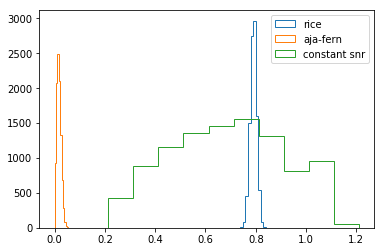

In [4]:
# scipy.rice
v = .79
sigma = .013
b = v/sigma
r = rice.rvs(b, scale = sigma, size=10000)
pl.hist(r,histtype ='step',label = 'rice')
print(np.mean(r))
print(np.std(r))

# aja-fernandes
N = []
for i in range(10000):
    g1 = np.random.normal(0,1,1) #mean, std, #of values
    g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR oh no
    R = np.sqrt(g1**2 + g2**2)[0]
    N.append(R*.013)
    
pl.hist(N,histtype = 'step',label = 'aja-fern')

    
print(np.mean(N))
print(np.std(N))


def NoiseRSNRtest(I,SNR):
    N = [] 
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR oh no
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append((I[i]/SNR)*R) #SNR = 1,10,22,100,150,inf
    return N
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
S1 = []
for i in range(int(10000/10)):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    for i in range(10):
        S1.append(NoiseRSNR(Sig,22)[i]) #SNR = 22 was established
pl.hist(S1,histtype = 'step',label = 'constant snr')

print(np.mean(S1))
print(np.std(S1))
pl.legend()

# welp. I guess use rician function.

In [5]:
# NEW RICIAN FUNCTION. SNR NOT RELEVANT. constant noise.
def NoiseRice(I,sigma): # noise with rician distribution
    N = [] 
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise measured!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=10)
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N

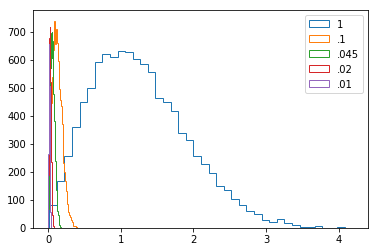

In [6]:
N1 = []
r1 = rice.rvs(0.005816/1, scale = 1, size=10000)
pl.hist(r1,histtype = 'step',label = '1',bins = 40)
r2 = rice.rvs(0.005816/.1, scale = .1, size=10000)
pl.hist(r2,histtype = 'step',label = '.1',bins = 40)
r3 = rice.rvs(0.005816/.045, scale = .045, size=10000)
pl.hist(r3,histtype = 'step',label = '.045',bins = 40)
r4 = rice.rvs(0.005816/.02, scale = .02, size=10000)
pl.hist(r4,histtype = 'step',label = '.02',bins = 40)
r5 = rice.rvs(0.005816/.01, scale = .01, size=10000)
pl.hist(r5,histtype = 'step',label = '.01',bins = 40)
pl.legend()
pl.show()

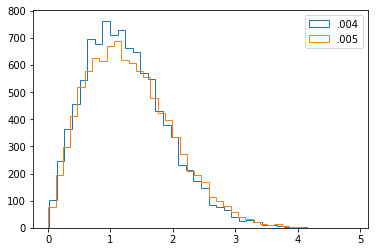

In [14]:
r1 = rice.rvs(0.0043/.0135, scale = 1, size=10000)
r2 = rice.rvs(0.0058/.0135, scale = 1, size=10000)
pl.hist(r1,histtype = 'step',label = '.004',bins = 40)
pl.hist(r2,histtype = 'step',label = '.005',bins = 40)
pl.legend()

In [15]:
def CreateParams(Param,Init):
    L = list(range(0,30000,3)) # USE TO SEPARATE F, D*, D
    for i in range(10000):
        Param[0].append(Init[L[i]]) #f
        Param[1].append(Init[L[i]+1]) #Ds
        Param[2].append(Init[L[i]+2]) #D
    return Paramn
    
def sortParams(*args):
    TSR = [[],[],[]] #SNR1
    TSR10 = [[],[],[]] #SNR10
    TSR22 = [[],[],[]] #SNR22
    TSR50 = [[],[],[]] #SNR50
    TSR75 = [[],[],[]] #SNR75
    TSR100 = [[],[],[]] #SNR100
    TSR125 = [[],[],[]] #SNR125
    TSR150 = [[],[],[]] #SNR150
    TSRinf = [[],[],[]] #no noise
    TSR = CreateParams(TSR,args[0])
    TSR10 = CreateParams(TSR10,args[1])
    TSR22 = CreateParams(TSR22,args[2])
    TSR50 = CreateParams(TSR50,args[3])
    TSR75 = CreateParams(TSR75,args[4])
    TSR100 = CreateParams(TSR100,args[5])
    TSR125 = CreateParams(TSR125,args[6])
    TSR150 = CreateParams(TSR150,args[7])
    TSRinf = CreateParams(TSRinf,args[8])
    return TSR,TSR10,TSR22,TSR50,TSR75,TSR100,TSR125,TSR150,TSRinf

# SNR FOR SPLIT FIT

In [10]:
# comparing SNR for SPLIT FIT, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR = [] #SNR1
TSR10 = [] #SNR10
TSR22 = [] #SNR22
TSR50 = [] #SNR50
TSR75 = [] #SNR75
TSR100 = [] #SNR100
TSR125 = [] #SNR125
TSR150 = [] #SNR150
TSRinf = [] #no noise
for i in range(100):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRice(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S1,2)
    TSR.append(ferr),TSR.append(Dserr),TSR.append(Derr)
    #SNR
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRice(Sig10,.1) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S10,2)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRice(Sig22,.045) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S22,2)
    TSR22.append(ferr),TSR22.append(Dserr),TSR22.append(Derr)
    #SNR50
    Sig50 = ivim(B,f,Ds,D)
    S50 = NoiseRice(Sig50,.02) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S50,2)
    TSR50.append(ferr),TSR50.append(Dserr),TSR50.append(Derr)
    #SNR75
    Sig75 = ivim(B,f,Ds,D)
    S75 = NoiseRice(Sig75,.013) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S75,2)
    TSR75.append(ferr),TSR75.append(Dserr),TSR75.append(Derr)
    #SNR100
    Sig100 = ivim(B,f,Ds,D)
    S100 = NoiseRice(Sig100,.01) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S100,2)
    TSR100.append(ferr),TSR100.append(Dserr),TSR100.append(Derr)
    #SNR125
    Sig125 = ivim(B,f,Ds,D)
    S125 = NoiseRice(Sig125,.008) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S125,2)
    TSR125.append(ferr),TSR125.append(Dserr),TSR125.append(Derr)
    #SNR150
    Sig150 = ivim(B,f,Ds,D)
    S150 = NoiseRice(Sig150,.0065) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S150,2)
    TSR150.append(ferr),TSR150.append(Dserr),TSR150.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRice(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,Sig,2)
    TSRinf.append(ferr),TSRinf.append(Dserr),TSRinf.append(Derr)

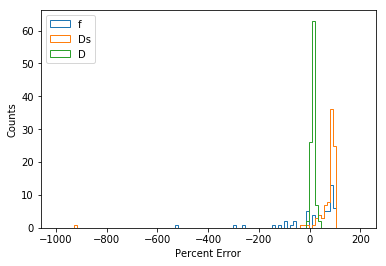

should get worse to better
average error 1:  99.99851444210877
average error 10:  -576.1124283051879
average error 22:  -476.9259752377648
average error 50:  -318.29400633105695
average error 75:  -171.2876208897168
average error 100:  -57.44368752710914
average error 125:  -227.56075695809113
average error 150:  -56.93471167766078
average error inf:  -6.541789988090039
absolute error 1:  99.99851444210877
absolute error 10:  665.2193396360054
absolute error 22:  549.7173983677801
absolute error 50:  373.942546948323
absolute error 75:  217.30256810170292
absolute error 100:  99.13813965645576
absolute error 125:  264.8980024185386
absolute error 150:  91.66217198236464
absolute error: inf 20.33925527525997


In [11]:
L = list(range(0,30000,3)) # USE TO SEPARATE F, D*, D
TSR22f = []
TSR22D = []
TSR22Ds = []
for i in range(100):
    TSR22f.append(TSR22[L[i]])
    TSR22Ds.append(TSR22[L[i]+1])
    TSR22D.append(TSR22[L[i]+2])
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR22f,bins = 100,range=(-1000,200),histtype = 'step',label = 'f')
pl.hist(TSR22Ds,bins = 100,range =(-1000,200),histtype = 'step',label = 'Ds')
pl.hist(TSR22D,bins = 100,range=(-1000,200),histtype = 'step',label = 'D')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1: ',np.mean(TSR))
print('average error 10: ',np.mean(TSR10))
print('average error 22: ',np.mean(TSR22))
print('average error 50: ',np.mean(TSR50))
print('average error 75: ',np.mean(TSR75))
print('average error 100: ',np.mean(TSR100))
print('average error 125: ',np.mean(TSR125))
print('average error 150: ',np.mean(TSR150))
print('average error inf: ',np.mean(TSRinf))
print('absolute error 1: ', np.sum([abs(i) for i in TSR])/len(TSR))
print('absolute error 10: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error 22: ', np.sum([abs(i) for i in TSR22])/len(TSR22))
print('absolute error 50: ', np.sum([abs(i) for i in TSR50])/len(TSR50))
print('absolute error 75: ', np.sum([abs(i) for i in TSR75])/len(TSR75))
print('absolute error 100: ', np.sum([abs(i) for i in TSR100])/len(TSR100))
print('absolute error 125: ', np.sum([abs(i) for i in TSR125])/len(TSR125))
print('absolute error 150: ', np.sum([abs(i) for i in TSR150])/len(TSR150))
print('absolute error: inf', np.sum([abs(i) for i in TSRinf])/len(TSRinf))

# SNR FOR SIMPLE FIT

In [13]:
# comparing SNR for SIMPLE FIT, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSRs = [] #SNR1
TSR10s = [] #SNR10
TSR22s = [] #SNR22
TSR50s = [] #SNR50
TSR75s = [] #SNR75
TSR100s = [] #SNR100
TSR125s = [] #SNR125
TSR150s = [] #SNR150
TSRinfs = [] #no noise
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()'
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRice(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S1)
    TSRs.append(ferr),TSRs.append(Dserr),TSRs.append(Derr)
    #SNR10
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRice(Sig10,.1) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S10)
    TSR10s.append(ferr),TSR10s.append(Dserr),TSR10s.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRice(Sig22,.045) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S22)
    TSR22s.append(ferr),TSR22s.append(Dserr),TSR22s.append(Derr)
    #SNR50
    Sig50 = ivim(B,f,Ds,D)
    S50 = NoiseRice(Sig50,.02) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S50)
    TSR50s.append(ferr),TSR50s.append(Dserr),TSR50s.append(Derr)
    #SNR75
    Sig75 = ivim(B,f,Ds,D)
    S75 = NoiseRice(Sig75,.013) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S75)
    TSR75s.append(ferr),TSR75s.append(Dserr),TSR75s.append(Derr)
    #SNR100
    Sig100 = ivim(B,f,Ds,D)
    S100 = NoiseRice(Sig100,.01) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S100)
    TSR100s.append(ferr),TSR100s.append(Dserr),TSR100s.append(Derr)
    #SNR125
    Sig125 = ivim(B,f,Ds,D)
    S125 = NoiseRice(Sig125,.008) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S125)
    TSR125s.append(ferr),TSR125s.append(Dserr),TSR125s.append(Derr)
    #SNR150
    Sig150 = ivim(B,f,Ds,D)
    S150 = NoiseRice(Sig150,.0065) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,S150)
    TSR150s.append(ferr),TSR150s.append(Dserr),TSR150s.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRice(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerun(f,Ds,D,Sig)
    TSRinfs.append(ferr),TSRinfs.append(Dserr),TSRinfs.append(Derr)

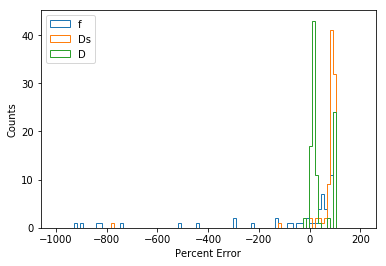

should get worse to better
average error 1:  99.97246978671765
average error 10:  -5.220008757649858
average error 22:  -109.74938492142893
average error 50:  -207.9039386958038
average error 75:  -216.97516649907283
average error 100:  -202.5206549275998
average error 125:  -189.03014597856318
average error 150:  -175.0517821068876
average error inf:  -4.457504291841148e-06
absolute error 1:  100.0139761104055
absolute error 10:  137.43558582192466
absolute error 22:  219.5276948551157
absolute error 50:  292.09223571351725
absolute error 75:  286.3555093391412
absolute error 100:  262.96828578891274
absolute error 125:  242.8347290492846
absolute error 150:  223.61517666909992
absolute error: inf 3.478039688874429e-05


In [14]:
L = list(range(0,30000,3)) # USE TO SEPARATE F, D*, D
TSR22fs = []
TSR22Ds = []
TSR22Dss = []
for i in range(100):
    TSR22fs.append(TSR22s[L[i]])
    TSR22Dss.append(TSR22s[L[i]+1])
    TSR22Ds.append(TSR22s[L[i]+2])
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR22fs,bins = 100,range=(-1000,200),histtype = 'step',label = 'f')
pl.hist(TSR22Dss,bins = 100,range =(-1000,200),histtype = 'step',label = 'Ds')
pl.hist(TSR22Ds,bins = 100,range=(-1000,200),histtype = 'step',label = 'D')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1: ',np.mean(TSRs))
print('average error 10: ',np.mean(TSR10s))
print('average error 22: ',np.mean(TSR22s))
print('average error 50: ',np.mean(TSR50s))
print('average error 75: ',np.mean(TSR75s))
print('average error 100: ',np.mean(TSR100s))
print('average error 125: ',np.mean(TSR125s))
print('average error 150: ',np.mean(TSR150s))
print('average error inf: ',np.mean(TSRinfs))
print('absolute error 1: ', np.sum([abs(i) for i in TSRs])/len(TSRs))
print('absolute error 10: ', np.sum([abs(i) for i in TSR10s])/len(TSR10s))
print('absolute error 22: ', np.sum([abs(i) for i in TSR22s])/len(TSR22s))
print('absolute error 50: ', np.sum([abs(i) for i in TSR50s])/len(TSR50s))
print('absolute error 75: ', np.sum([abs(i) for i in TSR75s])/len(TSR75s))
print('absolute error 100: ', np.sum([abs(i) for i in TSR100s])/len(TSR100s))
print('absolute error 125: ', np.sum([abs(i) for i in TSR125s])/len(TSR125s))
print('absolute error 150: ', np.sum([abs(i) for i in TSR150s])/len(TSR150s))
print('absolute error: inf', np.sum([abs(i) for i in TSRinfs])/len(TSRinfs))

# SNR for 2step fit

In [12]:
# comparing SNR for 2step, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR2 = [] #SNR1
TSR210 = [] #SNR10
TSR222 = [] #SNR22
TSR250 = [] #SNR50
TSR275 = [] #SNR75
TSR2100 = [] #SNR100
TSR2125 = [] #SNR125
TSR2150 = [] #SNR150
TSR2inf = [] #no noise
for i in range(1000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRice(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S1,2)
    TSR2.append(ferr),TSR2.append(Dserr),TSR2.append(Derr)
    #SNR10
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRice(Sig10,.1) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S10,2)
    TSR210.append(ferr),TSR210.append(Dserr),TSR210.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRice(Sig22,.045) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S22,2)
    TSR222.append(ferr),TSR222.append(Dserr),TSR222.append(Derr)
    #SNR50
    Sig50 = ivim(B,f,Ds,D)
    S50 = NoiseRice(Sig50,.02) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S50,2)
    TSR250.append(ferr),TSR250.append(Dserr),TSR250.append(Derr)
    #SNR75
    Sig75 = ivim(B,f,Ds,D)
    S75 = NoiseRice(Sig75,.013) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S75,2)
    TSR275.append(ferr),TSR275.append(Dserr),TSR275.append(Derr)
    #SNR100
    Sig100 = ivim(B,f,Ds,D)
    S100 = NoiseRice(Sig100,.001) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S100,2)
    TSR2100.append(ferr),TSR2100.append(Dserr),TSR2100.append(Derr)
    #SNR125
    Sig125 = ivim(B,f,Ds,D)
    S125 = NoiseRice(Sig125,.008) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S125,2)
    TSR2125.append(ferr),TSR2125.append(Dserr),TSR2125.append(Derr)
    #SNR150
    Sig150 = ivim(B,f,Ds,D)
    S150 = NoiseRice(Sig150,.0065) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S150,2)
    TSR2150.append(ferr),TSR2150.append(Dserr),TSR2150.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRice(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,Sig,2)
    TSR2inf.append(ferr),TSR2inf.append(Dserr),TSR2inf.append(Derr)

/Users/neuroimaging/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


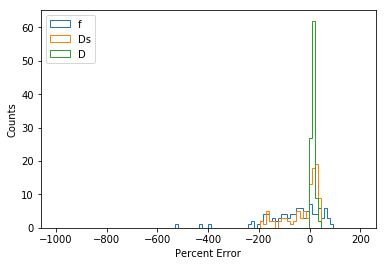

should get worse to better
average error 1:  -637.9095252522189
average error 10:  -73.73713745091632
average error 22:  -24.8287301941806
average error 50:  -6.136630171192414
average error 75:  -2.3191564390564556
average error 100:  0.09595773655030196
average error 125:  -0.8710662063528033
average error 150:  -0.6146300157409017
average error inf:  0.562802321660775
absolute error 1:  712.8133783700013
absolute error 10:  105.94328265587718
absolute error 22:  49.58714759924154
absolute error 50:  29.808630898252012
absolute error 75:  26.43959333542487
absolute error 100:  22.553066565111383
absolute error 125:  24.936473591757967
absolute error 150:  24.51288389941007
absolute error: inf 23.394863917864953


In [13]:
L = list(range(0,30000,3)) # USE TO SEPARATE F, D*, D
TSR222f = []
TSR222D = []
TSR222Ds = []
for i in range(100):
    TSR222f.append(TSR222[L[i]])
    TSR222Ds.append(TSR222[L[i]+1])
    TSR222D.append(TSR222[L[i]+2])
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR222f,bins = 100,range=(-1000,200),histtype = 'step',label = 'f')
pl.hist(TSR222Ds,bins = 100,range =(-1000,200),histtype = 'step',label = 'Ds')
pl.hist(TSR222D,bins = 100,range=(-1000,200),histtype = 'step',label = 'D')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1: ',np.mean(TSR2))
print('average error 10: ',np.mean(TSR210))
print('average error 22: ',np.mean(TSR222))
print('average error 50: ',np.mean(TSR250))
print('average error 75: ',np.mean(TSR275))
print('average error 100: ',np.mean(TSR2100))
print('average error 125: ',np.mean(TSR2125))
print('average error 150: ',np.mean(TSR2150))
print('average error inf: ',np.mean(TSR2inf))
print('absolute error 1: ', np.sum([abs(i) for i in TSR2])/len(TSR2))
print('absolute error 10: ', np.sum([abs(i) for i in TSR210])/len(TSR210))
print('absolute error 22: ', np.sum([abs(i) for i in TSR222])/len(TSR222))
print('absolute error 50: ', np.sum([abs(i) for i in TSR250])/len(TSR250))
print('absolute error 75: ', np.sum([abs(i) for i in TSR275])/len(TSR275))
print('absolute error 100: ', np.sum([abs(i) for i in TSR2100])/len(TSR2100))
print('absolute error 125: ', np.sum([abs(i) for i in TSR2125])/len(TSR2125))
print('absolute error 150: ', np.sum([abs(i) for i in TSR2150])/len(TSR2150))
print('absolute error: inf', np.sum([abs(i) for i in TSR2inf])/len(TSR2inf))

# SNR PLOTS

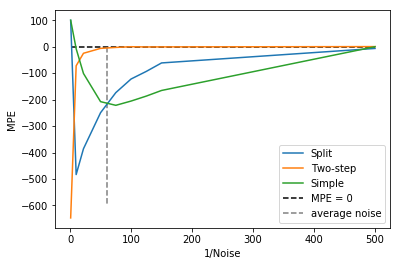

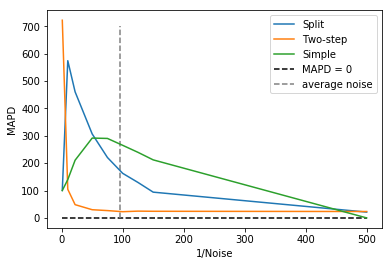

In [7]:
SPLITmpe = [99.74518910786865,
 -483.1948572995116,
 -385.6142728227402,
-249.4585800278958,
 -173.61837163218425,
 -122.13258423433412,
-93.33728879621904,
 -61.35961020235099,
-6.566759710995065] 
SPLITmapd = [100.20767757674916,
 573.9930293892044,
 460.2872732065038,
 306.61473619798204,
220.5977350283703,
162.7590674419487,
129.60492969662587,
94.07583861869416,
21.20187921285493]

SIMPLEmpe = [99.98730959828023,
-7.619582813061343,
 -101.24000268195627,
 -207.67961065988422,
 -221.52676131321365,
-205.46917429659257,
 -186.671508859224,
 -165.39841225170736,
 -4.310941743735804e-06]
SIMPLEmapd = [100.00390266625026,
 139.9065984139617,
 210.65708920693166,
 291.49198880142137,
 290.17941645786743,
 265.0515095152583,
  239.51012178801926,
211.92468165412976,
2.7953372695440822e-05]

TWOSTEPmpe = [-647.0853939500995,
 -72.1319058383865,
 -24.802490104257032,
 -6.374285952507587,
 -2.7771661630228706,
 -0.04588650294336509,
 -0.9349815858943629,
 -0.7160497563328354,
 0.38706573759258195] 
TWOSTEPmapd = [ 721.6666066156264,
104.47243417937948,
48.3960668849185,
29.942378647044404,
 26.762074733808085,
22.696915361982374,
 24.763492455057357,
 24.235571147163743,
23.41203208733118]


SNR = [1,10,22,50,75,100,125,150,500] # = 1/Noise
#Noise = [1,.1,.045,.02,.013,.01,.008,.0065,.0001] # = std of noise used
#pl.xlim(0,1)
pl.plot(SNR,SPLITmpe,label = 'Split')
pl.plot(SNR,TWOSTEPmpe,label = 'Two-step')
pl.plot(SNR,SIMPLEmpe,label = 'Simple')
pl.hlines(0,1,500,linestyle = '--',label = 'MPE = 0')
#pl.vlines(31,0,-600,linestyle='--',label = 'measured noise range',color='grey')
#pl.vlines(91,0,-600,linestyle='--',label = 'measured noise range',color='grey')
pl.vlines(61,0,-600,linestyle='--',label = 'average noise',color='grey')
pl.ylabel('MPE')
pl.xlabel('1/Noise')
pl.legend()
#pl.savefig('/Users/neuroimaging/Desktop/Noise.tif',dpi=1000)

pl.show()


pl.plot(SNR,SPLITmapd,label = 'Split')
pl.plot(SNR,TWOSTEPmapd,label = 'Two-step')
pl.plot(SNR,SIMPLEmapd,label = 'Simple')
pl.hlines(0,1,500,linestyle = '--',label = 'MAPD = 0')
#pl.vlines(31,0,700,linestyle='--',label = 'measured noise range',color='grey')
#pl.vlines(91,0,700,linestyle='--',label = 'measured noise range',color='grey')
pl.vlines(96.2,0,700,linestyle='--',label = 'average noise',color='grey')
pl.ylabel('MAPD')
pl.xlabel('1/Noise')
pl.legend()
pl.savefig('/Users/neuroimaging/Desktop/Noise.tif',dpi=1000)

pl.show()


Sorting By Parameter


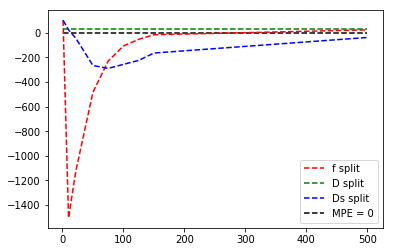

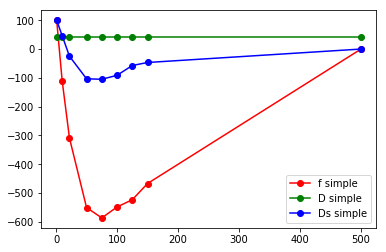

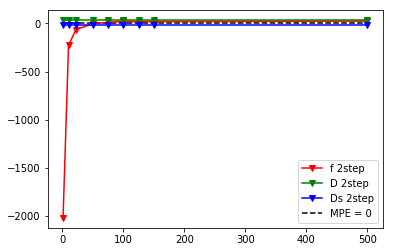

In [44]:
print('Sorting By Parameter')
#split fit
T1,T10,T22,T50,T75,T100,T125,T150,Tinf = sortParams(TSR,TSR10,TSR22,TSR50,TSR75,TSR100,TSR125,TSR150,TSRinf)
fMPE = []
DMPE = []
DsMPE = []
List = [T1,T10,T22,T50,T75,T100,T125,T150,Tinf]
for i in range(9):
    fMPE.append(np.mean(List[i][0]))
    DsMPE.append(np.mean(List[i][1]))
    DMPE.append(np.mean(List[1][2]))
    
SNR = [1,10,22,50,75,100,125,150,500]
pl.plot(SNR,fMPE,label = 'f split',linestyle = '--',color = 'r')
pl.plot(SNR,DMPE,label = 'D split',linestyle = '--',color = 'g')
pl.plot(SNR,DsMPE,label = 'Ds split',linestyle = '--',color = 'b')
pl.hlines(0,1,500,linestyle = '--',label = 'MPE = 0')
pl.legend()
pl.show()

#simple fit 
T1,T10,T22,T50,T75,T100,T125,T150,Tinf = sortParams(TSRs,TSR10s,TSR22s,TSR50s,TSR75s,TSR100s,TSR125s,TSR150s,TSRinfs)
fMPE = []
DMPE = []
DsMPE = []
List = [T1,T10,T22,T50,T75,T100,T125,T150,Tinf]
for i in range(9):
    fMPE.append(np.mean(List[i][0]))
    DsMPE.append(np.mean(List[i][1]))
    DMPE.append(np.mean(List[1][2]))
    
SNR = [1,10,22,50,75,100,125,150,500]
pl.plot(SNR,fMPE,label = 'f simple',marker = 'o',color = 'r')
pl.plot(SNR,DMPE,label = 'D simple',marker = 'o',color = 'g')
pl.plot(SNR,DsMPE,label = 'Ds simple',marker = 'o',color = 'b')
pl.legend()
pl.show()

#two step
T1,T10,T22,T50,T75,T100,T125,T150,Tinf = sortParams(TSR2,TSR210,TSR222,TSR250,TSR275,TSR2100,TSR2125,TSR2150,TSR2inf)
fMPE = []
DMPE = []
DsMPE = []
List = [T1,T10,T22,T50,T75,T100,T125,T150,Tinf]
for i in range(9):
    fMPE.append(np.mean(List[i][0]))
    DsMPE.append(np.mean(List[i][1]))
    DMPE.append(np.mean(List[1][2]))
    
SNR = [1,10,22,50,75,100,125,150,500]
pl.plot(SNR,fMPE,label = 'f 2step',marker = 'v',color = 'r')
pl.plot(SNR,DMPE,label = 'D 2step',marker = 'v',color = 'g')
pl.plot(SNR,DsMPE,label = 'Ds 2step',marker = 'v',color = 'b')
pl.hlines(0,1,500,linestyle = '--',label = 'MPE = 0')
pl.legend()
pl.show()


    